# E. coli Glycolytic Network Construction
## Growth Medium: Glucose
Growth data obtained from the following sources: 
- Gerosa, Luca et al. “Pseudo-transition Analysis Identifies the Key Regulators of Dynamic Metabolic Adaptations from Steady-State Data.” Cell systems vol. 1,4 (2015): 270-82. doi:10.1016/j.cels.2015.09.008


- Volkmer, Benjamin, and Matthias Heinemann. “Condition-dependent cell volume and concentration of Escherichia coli to facilitate data conversion for systems biology modeling.” PloS one vol. 6,7 (2011): e23126. doi:10.1371/journal.pone.0023126


### Import packages

In [1]:
# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass


import numpy as np
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt

import cobra
from cobra.io.json import load_json_model as load_cobra_json_model

import mass
from mass import MassConfiguration, MassModel, MassMetabolite, MassReaction, Simulation
from mass.io.json import save_json_model as save_mass_json_model
from mass.visualization import plot_comparison, plot_time_profile


print(f"COBRApy version: {cobra.__version__}")
print(f"MASSpy version: {mass.__version__}")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-20
COBRApy version: 0.23.0
MASSpy version: 0.1.7


### Set solver

In [2]:
MASSCONFIGURATION = MassConfiguration()
MASSCONFIGURATION.solver = "gurobi"

## Load COBRA model

In [3]:
cobra_model = load_cobra_json_model(f"./models/cobra/iML1515.json")

## Obtain Flux State
### Load growth data

In [4]:
medium = "Glucose"
'''
flux_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="flux_data",
    index_col=0
)
'''
flux_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="flux_data_reduced",
    index_col=0
)
flux_data = flux_data.loc[lambda x: x['Growth Medium'] == medium]
flux_data = flux_data.drop("Growth Medium", axis=1)
flux_data

,Flux (mmol * gDW-1 * h-1)
Rxn,
GLCptspp,9.613287
PGI,5.698950
PFK,7.057500
FBP,0.000000
FBA,7.057500
...,...
L_LACD2,0.000000
CYTBO3_4pp,38.191466
CYTBDpp,0.000000


### Set bounds
#### Growth rate and media

In [5]:
biomass_rxn = cobra_model.reactions.BIOMASS_Ec_iML1515_WT_75p37M
growth_rate = flux_data.loc[biomass_rxn.id][0] #This index is hard-coded based on which column has the flux value
biomass_rxn.bounds = (0, growth_rate)
biomass_rxn.bounds

(0, 0.455338783207954)

In [6]:
growth_rate

0.455338783207954

In [7]:
EX_glc__D_e = cobra_model.reactions.EX_glc__D_e
medium_uptake = flux_data.loc[EX_glc__D_e.id][0] #This index is hard-coded based on which column has the flux value
EX_glc__D_e.bounds = (medium_uptake, 0)
EX_glc__D_e.bounds

(-9.655, 0)

### Formulate QP minimization for fluxes

In [8]:
v_vars = []
v_data = []

# For irreversible enzyme pairs, flux data is given as Enzyme1 - Enzyme2 = value.
# To ensure all enzymes have some flux, add a percentage of the net flux for each enzyme
# The netflux will still remain the same value.
reverse_flux_percent = 0.1

irreversible_enzyme_pairs = [["PFK", "FBP"], ["PYK", "PPS"]]

for rid, flux in flux_data.itertuples():
    # Make adjustments to net flux of PFK/FBP and PYK/PPS to ensure
    # no target flux value is 0 in order to create an enzyme module.
    for irreversible_enzyme_pair in irreversible_enzyme_pairs:
        
        if rid in irreversible_enzyme_pair:
            flux1, flux2 = flux_data.loc[irreversible_enzyme_pair, "Flux (mmol * gDW-1 * h-1)"].values
            if flux1 == 0:
                flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
            if flux2 == 0:
                flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
            print(rid, flux)
            
    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)

# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)
F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
cobra_model.objective = objective[0]
cobra_model.objective_direction = "min"

flux_solution = cobra_model.optimize()
flux_solution

PFK 7.76325
FBP 0.7057500000000001
PYK 2.73493
PPS 0.24863000000000002


,fluxes,reduced_costs
CYTDK2,0.000000,0.0
XPPT,0.000000,0.0
HXPRT,0.000000,0.0
NDPK5,0.000000,0.0
SHK3Dr,0.211771,0.0
...,...,...
MPTS,0.000000,0.0
MOCOS,0.000000,0.0
BMOGDS2,0.000000,0.0
FESD2s,0.000000,0.0


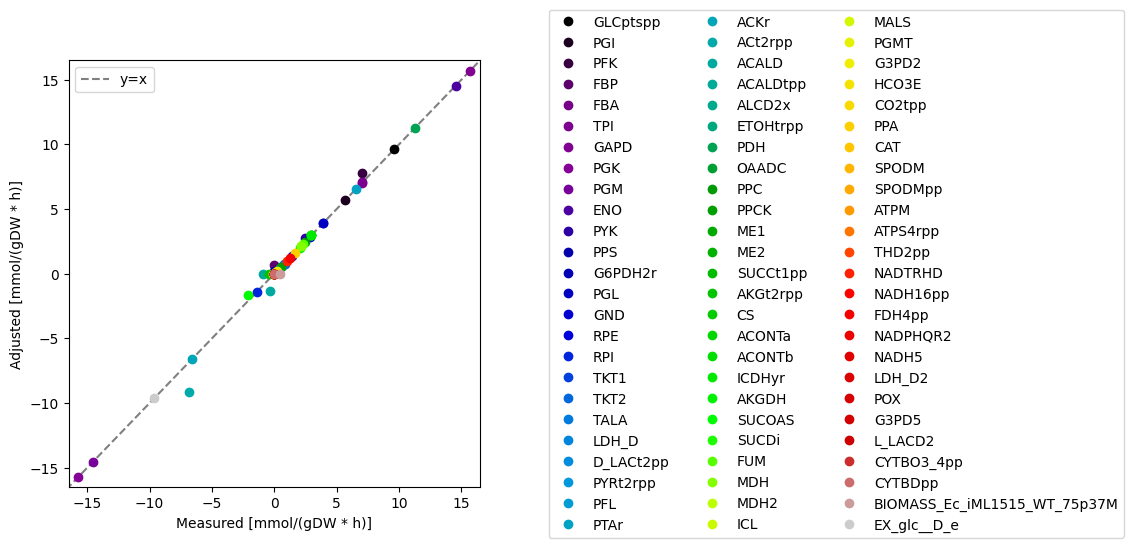

In [9]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_data["Flux (mmol * gDW-1 * h-1)"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_data.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-16.5, 16.5), ylim=(-16.5, 16.5),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()

#### Export data for analysis

In [10]:
flux_data_for_comparison = pd.concat(objs=(flux_data, flux_solution.fluxes), axis=1).dropna()
flux_data_for_comparison.index.name = "ID"
flux_data_for_comparison.columns = ["Initial", "Adjusted"]
flux_data_for_comparison.to_csv("./data/analysis_data/fluxes_extended.csv")

## Create MASS Model

In [11]:
# Create MassModel
mass_model = MassModel("CentralMetabolism", array_type="DataFrame")

# Reactions to extract into subnetwork
reaction_list = [
    "GLCptspp",
"PGI",
"PFK",
"FBP",
"FBA",
"TPI",
"GAPD",
"PGK",
"PGM",
"ENO",
"PYK",
"PPS",
"G6PDH2r",
"PGL",
"GND",
"RPE",
"RPI",
"TKT1",
"TKT2",
"TALA",
"LDH_D",
"D_LACt2pp",
"PYRt2rpp",
"PFL",
"PTAr",
"ACKr",
"ACt2rpp",
"ACALD",
"ACALDtpp",
"ALCD2x",
"ETOHtrpp",
"PDH",
"OAADC",
"PPC",
"PPCK",
"ME1",
"ME2",
"SUCCt1pp",
"AKGt2rpp",
"CS",
"ACONTa",
"ACONTb",
"ICDHyr",
"AKGDH",
"SUCOAS",
"SUCDi",
"FUM",
"MDH",
"MDH2",
"ICL",
"MALS",
"PGMT",
"G3PD2",
"HCO3E",
"CO2tpp",
"PPA",
"CAT",
"SPODM",
"SPODMpp",
"ATPM",
"ATPS4rpp",
"THD2pp",
"NADTRHD",
"NADH16pp",
"FDH4pp",
"NADPHQR2",
"NADH5",
"LDH_D2",
"POX",
"G3PD5",
"L_LACD2",
"CYTBO3_4pp",
"CYTBDpp",
]

cobra_reactions = cobra_model.reactions.get_by_any(reaction_list)
mass_model.add_reactions([MassReaction(rxn) for rxn in cobra_reactions])
mass_model

Name,CentralMetabolism
Memory address,0x01d708bcb188
Stoichiometric Matrix,70x73
Matrix Rank,58
Number of metabolites,70
Initial conditions defined,0/70
Number of reactions,73
Number of genes,68
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Convert flux units to M/s

In [12]:
T = 313.15
gas_constant = 0.008314
e_coli_density = 1.1 # g / mL assumption
volume = 3.2  # femtoliter

# Perform conversions
doubling_time_per_minute = np.log(2) / growth_rate * 60
cell_gDW = 42000 * doubling_time_per_minute**-1.232 * 1e-15
real_cell_total_weight = e_coli_density * (volume * 1e-12) # fL --> mL

# Assume water is 70%
adj_volume = volume * 0.7
gDW_L_conversion_factor = real_cell_total_weight / (adj_volume * 1e-15)

for reaction in mass_model.reactions.get_by_any(reaction_list):
    flux = flux_solution[reaction.id]
    reaction.steady_state_flux = flux * gDW_L_conversion_factor * 0.001 / 3600 

## Set equilibrium constants

In [13]:
Keq_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="Keq_data",
    index_col=0
)
for reaction in mass_model.reactions.get_by_any(reaction_list):
    reaction.Keq = Keq_data.loc[reaction.Keq_str][0]

In [14]:
conc_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="conc_data",
    index_col=0
)
conc_data = conc_data.loc[lambda x: x['Growth Medium'] == "Glucose"]
conc_data = conc_data.drop("Growth Medium", axis=1)
conc_data

,Concentration (mol * L-1)
ID,
10fthf_c,1.051286e-04
13dpg_c,5.507545e-05
23dhb_c,1.380000e-04
2ddg6p_c,1.247644e-05
2dmmql8,1.051286e-04
...,...
utp_c,8.290000e-03
val__L_c,4.020000e-03
xu5p__D_c,6.447318e-04


### Add PFK1 activator GDP

In [15]:
#gdp_c = MassMetabolite(cobra_model.metabolites.gdp_c)
# Set the activator as a constant
#gdp_c.fixed = True

#mass_model.add_metabolites(gdp_c)

### Set initial concentrations from growth data

In [16]:
mass_model.update_initial_conditions({
    mid: value for mid, value in conc_data.itertuples()
})

# Fix hydrogen and water as constants and set concentration to 1.
for metabolite in mass_model.metabolites.get_by_any(["h2o_c", "h_c"]):
    metabolite.fixed = True
    metabolite.initial_condition = 1

missing_ics = mass_model.metabolites.query(lambda m: m.initial_condition is None)
# Provide initial guesses for missing metabolites (pi_c, g3p_c, and lac__D_c)
print(missing_ics)
for metabolite in missing_ics:
    metabolite.initial_condition = 0.001

[<MassMetabolite glc__D_p at 0x1d708bcbac8>, <MassMetabolite 6pgl_c at 0x1d708bbd588>, <MassMetabolite lac__D_c at 0x1d708bb7688>, <MassMetabolite h_p at 0x1d708bb7208>, <MassMetabolite lac__D_p at 0x1d708bb2508>, <MassMetabolite pyr_p at 0x1d708bb2088>, <MassMetabolite ac_p at 0x1d708bb4f08>, <MassMetabolite acald_c at 0x1d708bb4488>, <MassMetabolite acald_p at 0x1d708bb0848>, <MassMetabolite etoh_c at 0x1d708bb0b48>, <MassMetabolite etoh_p at 0x1d708bb0448>, <MassMetabolite succ_p at 0x1d708ba7d88>, <MassMetabolite akg_p at 0x1d708ba7b08>, <MassMetabolite glx_c at 0x1d708b95348>, <MassMetabolite co2_p at 0x1d708b983c8>, <MassMetabolite h2o2_c at 0x1d708b93dc8>, <MassMetabolite o2s_c at 0x1d708b93e48>, <MassMetabolite h2o2_p at 0x1d708b93408>, <MassMetabolite o2_p at 0x1d708b93388>, <MassMetabolite o2s_p at 0x1d708b93348>, <MassMetabolite for_p at 0x1d708b87fc8>, <MassMetabolite lac__L_c at 0x1d708b83c88>]


mass\core\mass_model.py:1967 UserWarning: No metabolite found for '10fthf_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '23dhb_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2ddg6p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2dmmql8'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2dr5p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '4abut_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '4hbz_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '5mthf'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'aacoa_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'acgam1p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'acorn_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'ade_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'adn_c'
mass\core\mass_

### Formulate QP minimization for concentrations

In [17]:
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

In [18]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,
    equilibrium_reactions=[x.id for x in mass_model.reactions if x.steady_state_flux == 0]

)

conc_solver.setup_feasible_qp_problem(
    fixed_conc_bounds=list(mass_model.fixed),
)

conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
g6p_c,2.242760e-03,0.0
glc__D_p,1.000000e-03,0.0
pep_c,1.714436e-06,0.0
pyr_c,1.186056e-04,0.0
f6p_c,3.346820e-04,0.0
...,...,...
Keq_POX,7.927669e+15,0.0
Keq_G3PD5,3.001950e+06,0.0
Keq_L_LACD2,2.291433e+06,0.0
Keq_CYTBO3_4pp,2.128717e+15,0.0


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'gly_c', 'clpn181', 'gsn_c', 'anth_c', 'skm_c', 'sarcs_c', 'dhor__S_c', 'crn_c', 'malcoa', 'asp__L_c', 'damp_c', '5mthf', 'adn_c', 'camp_c', '23dhb_c', 'glyc__R_c', 'phe__L_c', 'cbasp_c', 'inost_c', 'btn', 'dctp_c', 'mobd', 'acgam1p_c', '2dr5p_c', 'dgsn_c', 'uacgam_c', 'mocogdp', 'thmpp', 'pg160', 'pheme', 'f1p_c', 'arg__L_c', 'met__L_c', 'udp_c', 'hxan_c', 'gam6p_c', 'h2o_c', '4hbz_c', 'cytd_c', '2ddg6p_c', 'gal1p_c', 'imp_c', 'fmn_c', 'dttp_c', 'dad_2_c', 'mococdp', 'man6p_c', 'orn_c', 'chor', 'hemeO', 'gtp_c', 'citr__L_c', 'clpn161', 'pro__L_c', 'tre6p_c', 'h_c', 'aacoa_c', 'agm_c', 'histd_c', 'adocbl', 'gln__L_c', 'ile__L_c', 'ura_c', 'pe160', 'acorn_c', 'pg181', 'glu__L_c', 'ser__L_c', 'gmp_c', 'phpyr_c', 'ptrc_c', 'pydx5p', 'asn__L_c', 'itp_c', 'aps_c', 'trp__L_c', 'ctp_c', 'mnl1p_c', 'ala__L_c', 'cys__L_c', 'enter', 'gthrd_c', 'pg161', '10fthf_c', 'csn_c', 'gdp_c', 'his__L_c', 'ala_B_c', 'clpn160', 'hcys__L_c',

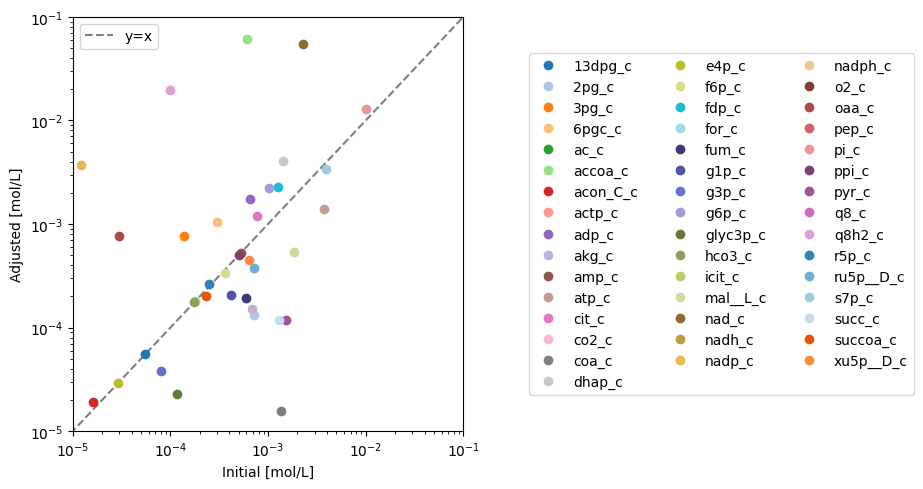

In [19]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_data["Concentration (mol * L-1)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_data.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e-1), ylim=(1e-5, 1e-1), xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    mass_model, conc_solution, concentrations=True, Keqs=True, inplace=True);

#### Export data for analysis

In [20]:
conc_data_for_comparison = pd.concat(objs=(conc_data, conc_solution.concentrations), axis=1).dropna()
conc_data_for_comparison.index.name = "ID"
conc_data_for_comparison.columns = ["Initial", "Adjusted"]
conc_data_for_comparison.to_csv("./data/analysis_data/concentrations_extended.csv")
conc_data_for_comparison

,Initial,Adjusted
ID,,
13dpg_c,0.000055,5.507545e-05
2pg_c,0.000725,1.312710e-04
3pg_c,0.000138,7.623383e-04
6pgc_c,0.000302,1.040886e-03
ac_c,0.000660,3.489012e+04
accoa_c,0.000606,6.123914e-02
acon_C_c,0.000016,1.893466e-05
actp_c,0.001070,4.984383e-01
adp_c,0.000656,1.755910e-03


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'Keq_PHEtex', 'Keq_PTHRpp', 'Keq_ADD', 'Keq_PPAt4pp', 'Keq_EX_fecrm_e', 'Keq_FE2tex', 'Keq_LALDO3', 'Keq_FEENTERES', 'Keq_NADH10', 'Keq_GLYCLTDy', 'Keq_EX_cm_e', 'Keq_CYTDH', 'Keq_PGP161abcpp', 'Keq_EX_cd2_e', 'Keq_ACOAD1fr', 'Keq_EX_dtmp_e', 'Keq_LADGMDH', 'Keq_DMSOR1', 'Keq_NACtex', 'Keq_ASNS2', 'Keq_LCTStex', 'Keq_ORNabcpp', 'Keq_HISTD', 'Keq_EX_feoxam_e', 'Keq_LPLIPAL2E120', 'Keq_UDPKAAT', 'Keq_DGSNtex', 'Keq_EX_udpacgal_e', 'Keq_PACOAT', 'Keq_EX_tre_e', 'Keq_3OAS100', 'Keq_TREtex', 'Keq_ANHGMtex', 'Keq_MMCD', 'Keq_3OAR161', 'Keq_DASYN180', 'Keq_GLGC', 'Keq_NTP12', 'Keq_EX_phe__L_e', 'Keq_NTD5pp', 'Keq_PGPP181pp', 'Keq_PSP_Lpp', 'Keq_SARCOX', 'Keq_EX_man6p_e', 'Keq_ACACT1r', 'Keq_CLt3_2pp', 'Keq_PRAGSr', 'Keq_SQtex', 'Keq_PLIPA1A180pp', 'Keq_EX_lipoate_e', 'Keq_ECA4COLIPAabctex', 'Keq_CLPNS141pp', 'Keq_UAG2E', 'Keq_MTHFC', 'Keq_GLYCAtex', 'Keq_EX_met__D_e', 'Keq_MOADSUx', 'Keq_SHSL1', 'Keq_EX_cu2_e', 'Keq_CYTDK1',

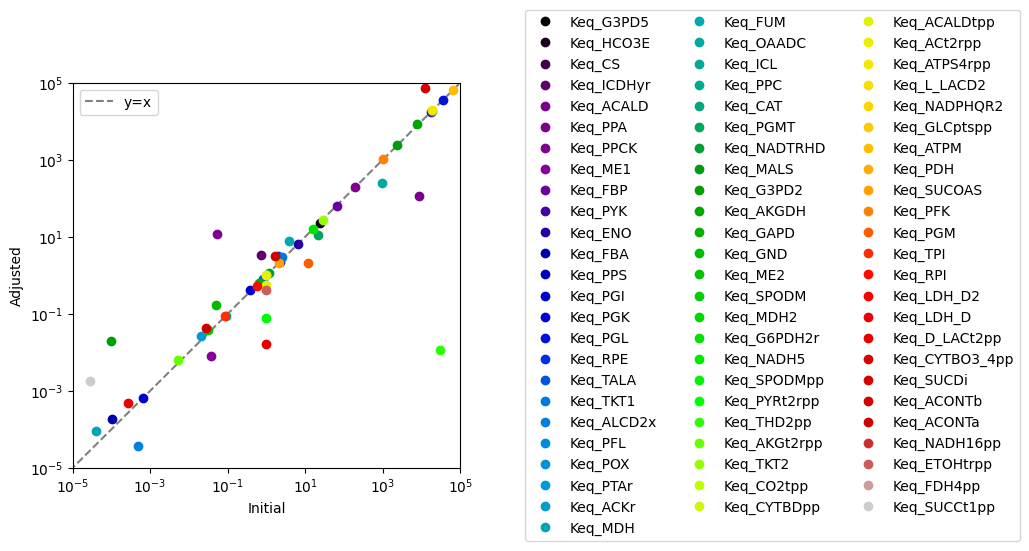

In [21]:
Keq_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

plot_comparison(
    x=Keq_data["Equilibrium Constant"], y=conc_solution,
    compare="Keqs", ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), xy_line=True,
    xy_legend="best", xlabel="Initial", ylabel="Adjusted")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    mass_model, conc_solution, concentrations=True, Keqs=True, inplace=True);

#### Export data for analysis

In [22]:
Keq_data_for_comparison = pd.concat(objs=(Keq_data, conc_solution.Keqs), axis=1).dropna()
Keq_data_for_comparison.index.name = "ID"
Keq_data_for_comparison.columns = ["Initial", "Adjusted"]
Keq_data_for_comparison.to_csv("./data/analysis_data/equilibrium_constants_extended.csv")
Keq_data_for_comparison

,Initial,Adjusted
ID,,
Keq_G3PD5,3.097852e+09,3.001950e+06
Keq_HCO3E,2.352797e+01,2.352797e+01
Keq_CS,4.465331e+06,4.465331e+06
Keq_ICDHyr,7.288431e-01,3.285634e+00
Keq_ACALD,8.884664e+03,1.129093e+02
...,...,...
Keq_ACONTa,2.777306e-02,4.330926e-02
Keq_NADH16pp,4.079883e+06,1.724759e+13
Keq_ETOHtrpp,1.000000e+00,4.279681e-01


In [23]:
# Fix Metabolite IDs as SBML compatible before next step
for metabolite in mass_model.metabolites:
    if metabolite.id[0].isdigit():
        metabolite.id = f"_{metabolite.id}"
mass_model.repair()

In [24]:
from pprint import pprint
pprint(vars(mass_model.metabolites.co2_c))

{'_annotation': {'bigg.metabolite': ['co2'],
                 'biocyc': ['META:CARBON-DIOXIDE'],
                 'chebi': ['CHEBI:23011',
                           'CHEBI:3283',
                           'CHEBI:48829',
                           'CHEBI:16526',
                           'CHEBI:13283',
                           'CHEBI:13285',
                           'CHEBI:13284',
                           'CHEBI:13282'],
                 'envipath': ['650babc9-9d68-4b73-9332-11972ca26f7b/compound/2ec3da94-5f50-4525-81b1-5607c5c7a3d3',
                              '32de3cf4-e3e6-4168-956e-32fa5ddb0ce1/compound/05f60af4-0a3f-4ead-9a29-33bb0f123379'],
                 'hmdb': ['HMDB01967'],
                 'inchi_key': ['CURLTUGMZLYLDI-UHFFFAOYSA-N'],
                 'kegg.compound': ['C00011'],
                 'kegg.drug': ['D00004'],
                 'metanetx.chemical': ['MNXM13'],
                 'reactome.compound': ['29376',
                                       '56685

In [25]:
# #Set the metabolite for CO2 as a fixed metabolite using the "fixed" attribute (e.g., co2_c.fixed = True, etc.)
# mass_model.metabolites.co2_c.fixed = True
# mass_model.metabolites.co2_c.initial_condition = 0.001

In [26]:
n_models = 1

In [27]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,
    equilibrium_reactions=[x.id for x in mass_model.reactions if x.steady_state_flux == 0]

)

conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(mass_model.fixed),
)
for variable in conc_solver.variables:
    try:
        met = mass_model.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=4)
conc_samples

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
0,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.23341,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002


In [28]:
mass_model.fixed

{<MassMetabolite h_c at 0x1d708bc9788>: 1,
 <MassMetabolite h2o_c at 0x1d708bc9d88>: 1}

In [29]:
for x in mass_model.reactions:
    if x.steady_state_flux == 0:
        print(x.id)

LDH_D
D_LACt2pp
PYRt2rpp
ACALDtpp
ALCD2x
ETOHtrpp
OAADC
ME1
ME2
SUCCt1pp
AKGt2rpp
PGMT
G3PD2
CAT
SPODMpp
THD2pp
NADPHQR2
NADH5
LDH_D2
POX
G3PD5
L_LACD2
CYTBDpp


In [30]:
mass_model.metabolites.co2_c

MassMetabolite identifier,co2_c
Name,CO2 CO2
Memory address,0x01d708bbd188
Formula,CO2
Compartment,c
Initial Condition,1576.9617169472906
In 12 reaction(s),"ME2, POX, ICDHyr, HCO3E, OAADC, GND, CO2tpp, PDH, PPC, ME1, PPCK, AKGDH"


In [31]:
mass_model.reactions.ICDHyr

Reaction identifier,ICDHyr
Name,Isocitrate dehydrogenase (NADP)
Memory address,0x01d708ba3c48
Subsystem,Citric Acid Cycle
Kinetic Reversibility,True
Stoichiometry,icit_c + nadp_c <=> akg_c + co2_c + nadph_c Isocitrate + Nicotinamide adenine dinucleotide phosphate <=> 2-Oxoglutarate + CO2 CO2 + Nicotinamide adenine dinucleotide phosphate - reduced
GPR,b1136
Bounds,"(-1000.0, 1000.0)"


In [32]:
mass_model.reactions[0]

Reaction identifier,GLCptspp
Name,D-glucose transport via PEP:Pyr PTS (periplasm)
Memory address,0x01d708bcba08
Subsystem,"Transport, Inner Membrane"
Kinetic Reversibility,True
Stoichiometry,glc__D_p + pep_c <=> g6p_c + pyr_c D-Glucose + Phosphoenolpyruvate <=> D-Glucose 6-phosphate + Pyruvate
GPR,(b1621 and b2415 and b2417 and b2416) or (b1101 and b2416 and b2415 and b2417) or (b1819 and b2415 and b1818 and b1817 and b2416)
Bounds,"(0.0, 1000.0)"


### Balance network with pseudoreactions and calculate PERCs

In [33]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = mass_model.copy()
    new_model.id += "_C{0:d}".format(idx)
    print(f"Creating model {new_model.id}")
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)
    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))

Creating model CentralMetabolism_C0
Number of models in ensemble: 1


sim_values_to_set
try setting perturbations
Went into reset = False if loop of _set_values_in_roadrunner
Finished for loop of _set_values_in_roadrunner


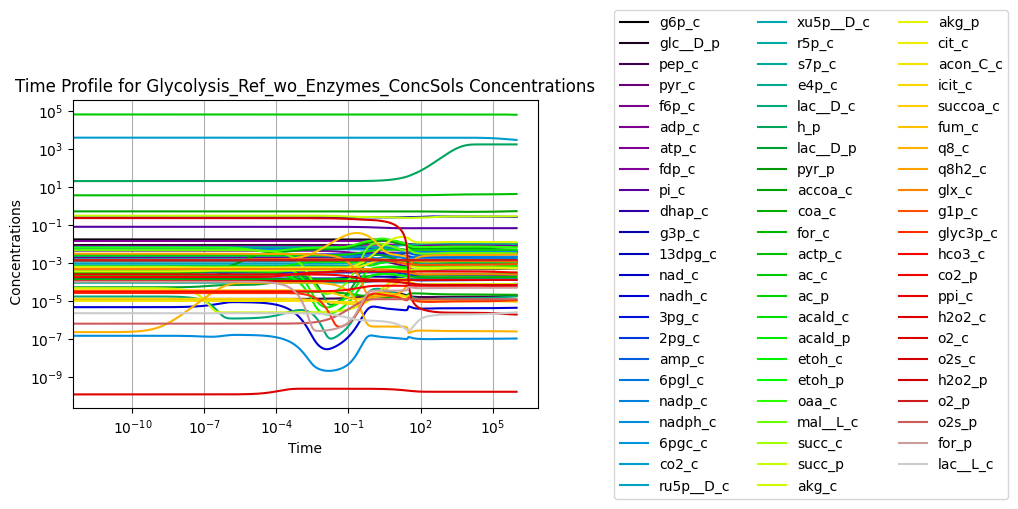

In [34]:
reference_model = models_for_ensemble[0].copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(reference_model, time=(0, tfinal))
conc_sol_orig.view_time_profile()

In [35]:
conc_df = conc_sol_orig.to_frame()
conc_df

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
2.494698e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
4.989396e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
7.484093e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
1.527795e-11,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.523953e+05,0.009514,0.003564,0.000019,0.000525,0.001096,0.003567,0.009257,0.009415,0.068496,0.004203,...,0.000319,0.000130,1.703559e-10,0.000002,0.000070,0.001393,0.001438,1.259266e-05,0.000051,0.000003
9.666698e+05,0.009515,0.003564,0.000019,0.000525,0.001097,0.003567,0.009257,0.009417,0.068494,0.004204,...,0.000319,0.000130,1.703559e-10,0.000002,0.000070,0.001393,0.001438,1.259266e-05,0.000051,0.000003
9.809443e+05,0.009517,0.003563,0.000019,0.000525,0.001097,0.003567,0.009257,0.009419,0.068492,0.004205,...,0.000318,0.000130,1.703559e-10,0.000002,0.000070,0.001393,0.001438,1.259266e-05,0.000051,0.000003


In [36]:
flux_df = flux_sol_orig.to_frame()
flux_df

,GLCptspp,PGI,PFK,FBP,FBA,TPI,GAPD,PGK,PGM,ENO,...,SK_q8_c,SK_q8h2_c,SK_glx_c,SK_hco3_c,SK_co2_p,SK_ppi_c,SK_h2o2_c,SK_o2_c,SK_o2s_c,SK_for_p
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.494698e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,1.328719e-07,9.845200e-12,6.731993e-19,6.723015e-16,1.184592e-12,4.993303e-15,1.102797e-14,6.696806e-12,4.771907e-20,7.111373e-15
4.989396e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,2.657433e-07,1.969036e-11,1.346399e-18,1.344603e-15,2.369298e-12,9.986607e-15,2.205594e-14,1.339359e-11,9.543813e-20,1.423427e-14
7.484093e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,3.986142e-07,2.953548e-11,2.019598e-18,2.016905e-15,3.554117e-12,1.497991e-14,3.308391e-14,2.009034e-11,1.431572e-19,2.136869e-14
1.527795e-11,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,8.137217e-07,6.029304e-11,4.125568e-18,4.117272e-15,7.256431e-12,3.058004e-14,6.753715e-14,4.101196e-11,2.921038e-19,4.373287e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.523953e+05,0.002516,0.001323,0.002307,0.000200,0.002107,0.002111,0.004689,-0.004689,-0.004811,0.004811,...,7.777225e-06,7.777258e-06,5.759807e-06,7.078314e-05,6.953073e-03,3.455131e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.868565e-04
9.666698e+05,0.002516,0.001323,0.002307,0.000200,0.002107,0.002112,0.004689,-0.004689,-0.004811,0.004811,...,7.764950e-06,7.764982e-06,5.760687e-06,7.072118e-05,6.947219e-03,3.455153e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.868377e-04
9.809443e+05,0.002516,0.001324,0.002308,0.000200,0.002108,0.002112,0.004690,-0.004690,-0.004812,0.004812,...,7.753176e-06,7.753207e-06,5.761531e-06,7.066172e-05,6.941601e-03,3.455174e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.868198e-04


# Checking reaction related to glucose

In [37]:
model = models_for_ensemble[0]

In [38]:
model.metabolites.glc__D_p

MassMetabolite identifier,glc__D_p
Name,D-Glucose
Memory address,0x01d7084e93c8
Formula,C6H12O6
Compartment,p
Initial Condition,0.008899422406411254
In 2 reaction(s),"SK_glc__D_p, GLCptspp"


In [39]:
model.reactions.SK_glc__D_p

Reaction identifier,SK_glc__D_p
Name,D-Glucose sink
Memory address,0x01d708800688
Subsystem,
Kinetic Reversibility,True
Stoichiometry,<=> glc__D_p <=> D-Glucose
GPR,
Bounds,"(-1000.0, 1000.0)"


In [40]:
model.reactions.SK_glc__D_p.boundary_metabolite

'glc__D_b'

In [41]:
model.reactions.SK_glc__D_p.rate

kf_SK_glc__D_p*(glc__D_b - glc__D_p(t)/Keq_SK_glc__D_p)

In [42]:
model.reactions.SK_glc__D_p.Keq

1

In [43]:
model.reactions.SK_glc__D_p.kf

0.47152227504904454

## Convert glucose uptake to bioprocess units

In [44]:
# unit is M/s
mass_rate_vol_spec = flux_df['SK_glc__D_p'].iloc[-1]*3600*180
mass_rate_gDW_spec = mass_rate_vol_spec/gDW_L_conversion_factor
print('The volume specific glucose sink rate is', np.round(mass_rate_vol_spec,2), 'grams per liter per hour (g/L/h).')
print('The biomass specific glucose sink rate is', np.round(mass_rate_gDW_spec,2), 'grams per gDW per hour (g/gDW/h).')

The volume specific glucose sink rate is 1630.94 grams per liter per hour (g/L/h).
The biomass specific glucose sink rate is 1.04 grams per gDW per hour (g/gDW/h).


In [45]:
# unit is M/s
mass_rate_vol_spec = flux_df['GLCptspp'].iloc[-1]*3600*180
mass_rate_gDW_spec = mass_rate_vol_spec/gDW_L_conversion_factor
print('The volume specific glucose uptake rate is', np.round(mass_rate_vol_spec,2), 'grams per liter per hour (g/L/h).')
print('The biomass specific glucose uptake rate is', np.round(mass_rate_gDW_spec,2), 'grams per gDW per hour (g/gDW/h).')

The volume specific glucose uptake rate is 1630.94 grams per liter per hour (g/L/h).
The biomass specific glucose uptake rate is 1.04 grams per gDW per hour (g/gDW/h).


In [46]:
print("Boundary Reaction and Values\n-----------------------------")
reaction = model.boundary[1]
boundary_met = reaction.boundary_metabolite
bc_value = model.boundary_conditions.get(boundary_met)
print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))

Boundary Reaction and Values
-----------------------------
SK_glc__D_p:  <=> glc__D_p
glc__D_b: 0.008899422406411254



# Changing glucose boundary

In [47]:
model.add_custom_rate(
    model.reactions.SK_glc__D_p,
    custom_rate="kf_SK_glc__D_p * glc__D_b")
print(model.reactions.SK_glc__D_p.rate)

glc__D_b*kf_SK_glc__D_p


In [48]:
model.reactions.SK_glc__D_p.kf = 1.0
model.reactions.SK_glc__D_p.kf

1.0

In [49]:
model.reactions.SK_glc__D_p

Reaction identifier,SK_glc__D_p
Name,D-Glucose sink
Memory address,0x01d708800688
Subsystem,
Kinetic Reversibility,True
Stoichiometry,<=> glc__D_p <=> D-Glucose
GPR,
Bounds,"(-1000.0, 1000.0)"


## This is the sink flux from previous simulation

In [50]:
flux_df['SK_glc__D_p'].iloc[-1]

0.0025168799016628144

## 100 % of glucose uptake

sim_values_to_set
try setting perturbations
Went into reset = False if loop of _set_values_in_roadrunner
Finished for loop of _set_values_in_roadrunner


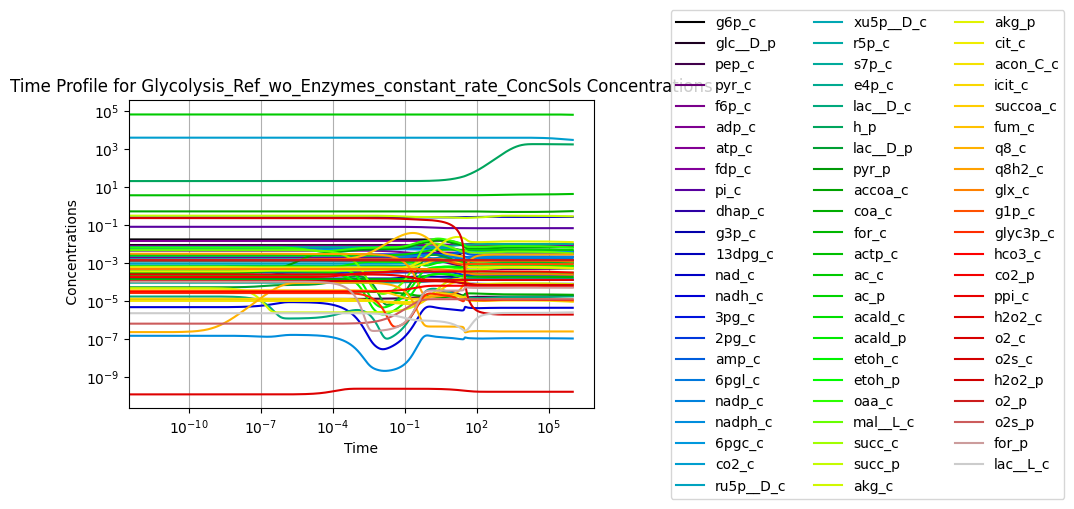

In [51]:
reference_model = model.copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes_constant_rate"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(
    reference_model,
    time=(0, tfinal),
    perturbations={"glc__D_b":"0.0025168795*1.0"}
)
conc_sol_orig.view_time_profile()

In [52]:
conc_df = conc_sol_orig.to_frame()
conc_df

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
2.494698e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
4.989396e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
7.484093e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
1.527795e-11,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.178480e+05,0.009521,0.003569,0.000019,0.000525,0.001097,0.003568,0.009256,0.009421,0.068497,0.004205,...,0.000319,0.000130,1.703559e-10,0.000002,0.000070,0.001393,0.001438,1.259266e-05,0.000051,0.000003
9.398650e+05,0.009520,0.003567,0.000019,0.000525,0.001097,0.003568,0.009256,0.009421,0.068495,0.004205,...,0.000319,0.000130,1.703559e-10,0.000002,0.000070,0.001393,0.001438,1.259266e-05,0.000051,0.000003
9.618820e+05,0.009520,0.003565,0.000019,0.000525,0.001097,0.003567,0.009257,0.009421,0.068493,0.004205,...,0.000319,0.000130,1.703559e-10,0.000002,0.000070,0.001393,0.001438,1.259266e-05,0.000051,0.000003


In [53]:
flux_df = flux_sol_orig.to_frame()
flux_df

,GLCptspp,PGI,PFK,FBP,FBA,TPI,GAPD,PGK,PGM,ENO,...,SK_q8_c,SK_q8h2_c,SK_glx_c,SK_hco3_c,SK_co2_p,SK_ppi_c,SK_h2o2_c,SK_o2_c,SK_o2s_c,SK_for_p
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.494698e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,1.328719e-07,9.845200e-12,6.731993e-19,6.723015e-16,1.184592e-12,4.993303e-15,1.102797e-14,6.696806e-12,4.771907e-20,7.111373e-15
4.989396e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,2.657433e-07,1.969036e-11,1.346399e-18,1.344603e-15,2.369298e-12,9.986607e-15,2.205594e-14,1.339359e-11,9.543813e-20,1.423427e-14
7.484093e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,3.986142e-07,2.953548e-11,2.019598e-18,2.016905e-15,3.554117e-12,1.497991e-14,3.308391e-14,2.009034e-11,1.431572e-19,2.136869e-14
1.527795e-11,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,8.137217e-07,6.029304e-11,4.125568e-18,4.117272e-15,7.256431e-12,3.058004e-14,6.753715e-14,4.101196e-11,2.921038e-19,4.373287e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.178480e+05,0.002517,0.001324,0.002308,0.000200,0.002108,0.002112,0.004690,-0.004690,-0.004812,0.004812,...,7.734344e-06,7.734342e-06,5.756098e-06,7.097020e-05,6.970624e-03,3.455116e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.867910e-04
9.398650e+05,0.002517,0.001324,0.002308,0.000200,0.002108,0.002112,0.004690,-0.004690,-0.004812,0.004812,...,7.735396e-06,7.735394e-06,5.757887e-06,7.086438e-05,6.960661e-03,3.455139e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.867926e-04
9.618820e+05,0.002517,0.001324,0.002308,0.000200,0.002108,0.002112,0.004690,-0.004690,-0.004812,0.004812,...,7.736396e-06,7.736394e-06,5.759568e-06,7.076501e-05,6.951304e-03,3.455161e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.867941e-04


In [54]:
0.002517*1.0

0.002517

## 90 % of glucose uptake

sim_values_to_set
try setting perturbations
Went into reset = False if loop of _set_values_in_roadrunner
Finished for loop of _set_values_in_roadrunner


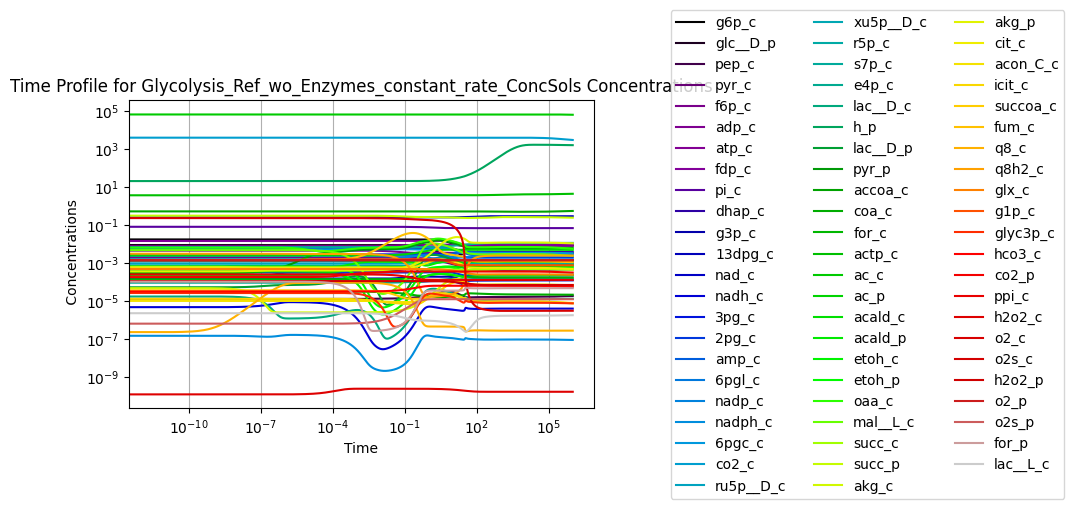

In [55]:
reference_model = model.copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes_constant_rate"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(
    reference_model,
    time=(0, tfinal),
    perturbations={"glc__D_b":"0.0025168795*0.9"}
)
conc_sol_orig.view_time_profile()

In [56]:
conc_df = conc_sol_orig.to_frame()
conc_df

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
2.494698e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
4.989396e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
7.484093e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
1.527795e-11,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.273341e+05,0.008288,0.003347,0.000018,0.000469,0.000990,0.003566,0.009266,0.008263,0.068975,0.003758,...,0.000318,0.000131,1.703559e-10,0.000003,0.000070,0.001393,0.001438,1.259266e-05,0.000048,0.000002
9.483857e+05,0.008287,0.003345,0.000018,0.000469,0.000990,0.003566,0.009266,0.008263,0.068973,0.003758,...,0.000318,0.000131,1.703559e-10,0.000003,0.000070,0.001393,0.001438,1.259266e-05,0.000048,0.000002
9.694372e+05,0.008287,0.003343,0.000019,0.000469,0.000990,0.003566,0.009266,0.008263,0.068971,0.003758,...,0.000318,0.000131,1.703559e-10,0.000003,0.000070,0.001393,0.001438,1.259266e-05,0.000048,0.000002


In [57]:
flux_df = flux_sol_orig.to_frame()
flux_df

,GLCptspp,PGI,PFK,FBP,FBA,TPI,GAPD,PGK,PGM,ENO,...,SK_q8_c,SK_q8h2_c,SK_glx_c,SK_hco3_c,SK_co2_p,SK_ppi_c,SK_h2o2_c,SK_o2_c,SK_o2s_c,SK_for_p
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.494698e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,1.328719e-07,9.845200e-12,6.731993e-19,6.723015e-16,1.184592e-12,4.993303e-15,1.102797e-14,6.696806e-12,4.771907e-20,7.111373e-15
4.989396e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,2.657433e-07,1.969036e-11,1.346399e-18,1.344603e-15,2.369298e-12,9.986607e-15,2.205594e-14,1.339359e-11,9.543813e-20,1.423427e-14
7.484093e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,3.986142e-07,2.953548e-11,2.019598e-18,2.016905e-15,3.554117e-12,1.497991e-14,3.308391e-14,2.009034e-11,1.431572e-19,2.136869e-14
1.527795e-11,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,8.137217e-07,6.029304e-11,4.125568e-18,4.117272e-15,7.256431e-12,3.058004e-14,6.753715e-14,4.101196e-11,2.921038e-19,4.373287e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.273341e+05,0.002265,0.001136,0.002085,0.000175,0.001909,0.001915,0.004342,-0.004342,-0.004490,0.004490,...,1.710841e-05,1.710841e-05,5.863470e-06,7.046599e-05,6.936721e-03,3.450144e-04,2.819638e-07,8.334590e-03,5.639277e-07,3.003728e-04
9.483857e+05,0.002265,0.001136,0.002085,0.000175,0.001909,0.001915,0.004342,-0.004342,-0.004490,0.004490,...,1.711114e-05,1.711114e-05,5.865096e-06,7.036280e-05,6.927007e-03,3.450166e-04,2.819638e-07,8.334590e-03,5.639277e-07,3.003765e-04
9.694372e+05,0.002265,0.001136,0.002085,0.000175,0.001909,0.001915,0.004343,-0.004343,-0.004490,0.004490,...,1.711373e-05,1.711373e-05,5.866630e-06,7.026555e-05,6.917852e-03,3.450188e-04,2.819638e-07,8.334590e-03,5.639277e-07,3.003801e-04


In [58]:
0.002517*0.9

0.0022653

## 50 % of glucose uptake 

sim_values_to_set
try setting perturbations
Went into reset = False if loop of _set_values_in_roadrunner
Finished for loop of _set_values_in_roadrunner


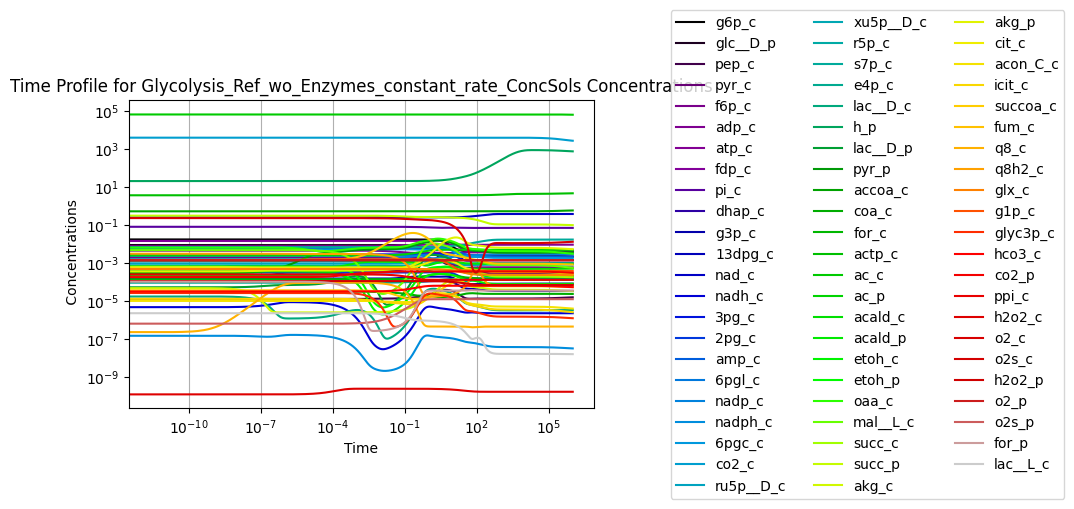

In [59]:
reference_model = model.copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes_constant_rate"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(
    reference_model,
    time=(0, tfinal),
    perturbations={"glc__D_b":"0.0025168795*0.5"}
)
conc_sol_orig.view_time_profile()

In [60]:
conc_df = conc_sol_orig.to_frame()
conc_df

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
2.494698e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
4.989396e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
7.484093e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
1.527795e-11,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.140997e+05,0.004197,0.002182,0.000016,0.000278,0.000597,0.003574,0.009276,0.004589,0.070910,0.002209,...,0.000309,0.000131,1.703559e-10,0.013133,0.000070,0.001393,0.001438,1.259266e-05,0.000036,1.622735e-08
9.401241e+05,0.004196,0.002180,0.000016,0.000278,0.000597,0.003574,0.009276,0.004589,0.070907,0.002210,...,0.000308,0.000131,1.703559e-10,0.013149,0.000070,0.001393,0.001438,1.259266e-05,0.000036,1.622228e-08
9.661485e+05,0.004196,0.002178,0.000016,0.000279,0.000597,0.003574,0.009276,0.004589,0.070904,0.002210,...,0.000308,0.000131,1.703559e-10,0.013164,0.000070,0.001393,0.001438,1.259266e-05,0.000036,1.621752e-08


In [61]:
flux_df = flux_sol_orig.to_frame()
flux_df

,GLCptspp,PGI,PFK,FBP,FBA,TPI,GAPD,PGK,PGM,ENO,...,SK_q8_c,SK_q8h2_c,SK_glx_c,SK_hco3_c,SK_co2_p,SK_ppi_c,SK_h2o2_c,SK_o2_c,SK_o2s_c,SK_for_p
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.494698e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,1.328719e-07,9.845200e-12,6.731993e-19,6.723015e-16,1.184592e-12,4.993303e-15,1.102797e-14,6.696806e-12,4.771907e-20,7.111373e-15
4.989396e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,2.657433e-07,1.969036e-11,1.346399e-18,1.344603e-15,2.369298e-12,9.986607e-15,2.205594e-14,1.339359e-11,9.543813e-20,1.423427e-14
7.484093e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,3.986142e-07,2.953548e-11,2.019598e-18,2.016905e-15,3.554117e-12,1.497991e-14,3.308391e-14,2.009034e-11,1.431572e-19,2.136869e-14
1.527795e-11,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,8.137217e-07,6.029304e-11,4.125568e-18,4.117272e-15,7.256431e-12,3.058004e-14,6.753715e-14,4.101196e-11,2.921038e-19,4.373287e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.140997e+05,0.001258,0.000530,0.001258,0.000097,0.001161,0.001170,0.002933,-0.002933,-0.003183,0.003183,...,8.026945e-05,8.026945e-05,6.127250e-06,6.446947e-05,6.436290e-03,3.429646e-04,2.819638e-07,7.865743e-03,5.639277e-07,3.646825e-04
9.401241e+05,0.001258,0.000530,0.001258,0.000097,0.001161,0.001170,0.002933,-0.002933,-0.003184,0.003184,...,8.027042e-05,8.027042e-05,6.129374e-06,6.428378e-05,6.418803e-03,3.429683e-04,2.819638e-07,7.865172e-03,5.639277e-07,3.646832e-04
9.661485e+05,0.001258,0.000529,0.001258,0.000097,0.001161,0.001170,0.002933,-0.002933,-0.003184,0.003184,...,8.027133e-05,8.027133e-05,6.131358e-06,6.411041e-05,6.402476e-03,3.429717e-04,2.819638e-07,7.864637e-03,5.639277e-07,3.646839e-04


In [62]:
0.002517*0.5

0.0012585

# Oscillation of the glucose availability

## Oscillating around 50 % of glucose uptake 

In [63]:
sym.sympify("0.00126*(sin(t/10)+1)")

0.00126*sin(t/10) + 0.00126

sim_values_to_set
try setting perturbations
reset = true in perturbations
Went into reset = true if loop of _set_values_in_roadrunner


C:\Users\jonruh\AppData\Local\anaconda3\envs\masspy_env\lib\site-packages\roadrunner\roadrunner.py:4622 UserWarning: Simulation requested end time point (1000000.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(0, 1000000.0, 1001)
  * Setting r.integrator.variable_step_size to 'False'
  * Setting r.integrator.max_output_rows to a larger number 


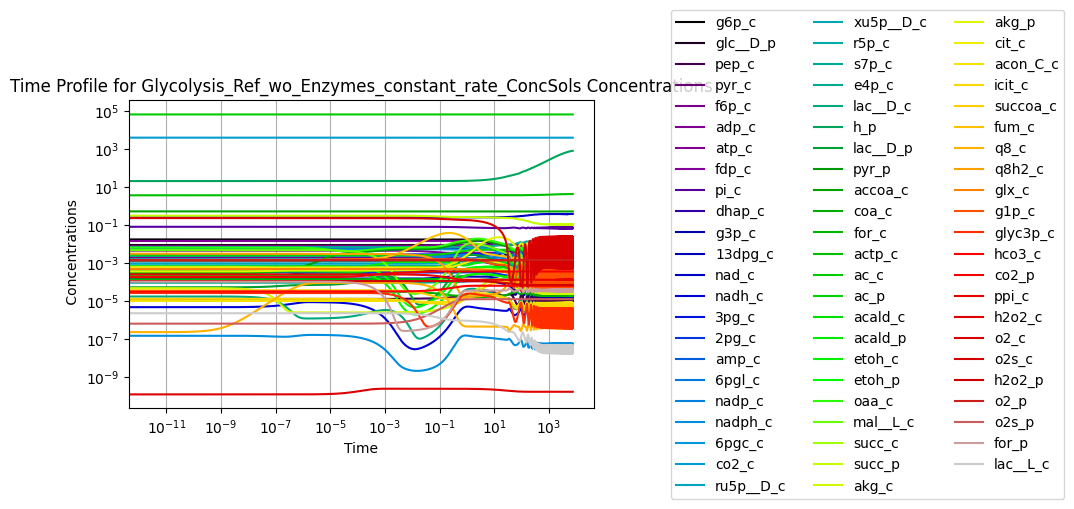

In [64]:
reference_model = model.copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes_constant_rate"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(
    reference_model,
    time=(0, tfinal),
    perturbations={"glc__D_b":"0.0025168795*0.5*(sin(t/10)+1)"}
)
conc_sol_orig.view_time_profile()

In [65]:
conc_df = conc_sol_orig.to_frame()
conc_df

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
2.494698e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
4.989396e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
7.484093e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
1.527795e-11,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7.558247e+03,0.007669,0.009331,0.000008,0.000284,0.000906,0.003707,0.009049,0.005733,0.068313,0.002518,...,0.000360,0.000130,1.703559e-10,0.021141,0.000070,0.001393,0.001438,1.259266e-05,0.000036,1.866906e-08
7.558406e+03,0.007719,0.009295,0.000008,0.000286,0.000912,0.003707,0.009049,0.005782,0.068280,0.002539,...,0.000360,0.000130,1.703559e-10,0.021007,0.000070,0.001393,0.001438,1.259266e-05,0.000036,1.862911e-08
7.558517e+03,0.007754,0.009268,0.000008,0.000287,0.000916,0.003706,0.009049,0.005815,0.068257,0.002553,...,0.000360,0.000130,1.703559e-10,0.020913,0.000070,0.001393,0.001438,1.259266e-05,0.000036,1.860217e-08


In [66]:
conc_df.to_excel('oscillating_conc.xlsx')

In [67]:
flux_df = flux_sol_orig.to_frame()
flux_df

,GLCptspp,PGI,PFK,FBP,FBA,TPI,GAPD,PGK,PGM,ENO,...,SK_q8_c,SK_q8h2_c,SK_glx_c,SK_hco3_c,SK_co2_p,SK_ppi_c,SK_h2o2_c,SK_o2_c,SK_o2s_c,SK_for_p
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.494698e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,1.328719e-07,9.845200e-12,6.731993e-19,6.723015e-16,1.184592e-12,4.993303e-15,1.102797e-14,6.696806e-12,4.771907e-20,7.111373e-15
4.989396e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,2.657433e-07,1.969036e-11,1.346399e-18,1.344603e-15,2.369298e-12,9.986607e-15,2.205594e-14,1.339359e-11,9.543813e-20,1.423427e-14
7.484093e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,3.986142e-07,2.953548e-11,2.019598e-18,2.016905e-15,3.554117e-12,1.497991e-14,3.308391e-14,2.009034e-11,1.431572e-19,2.136869e-14
1.527795e-11,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,8.137217e-07,6.029304e-11,4.125568e-18,4.117272e-15,7.256431e-12,3.058004e-14,6.753715e-14,4.101196e-11,2.921038e-19,4.373287e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7.558247e+03,0.002692,0.001056,0.001864,0.000122,0.001436,0.001317,0.003407,-0.003404,-0.003567,0.003561,...,7.969762e-05,8.061176e-05,5.781417e-06,9.236174e-05,9.062680e-03,3.456659e-04,2.819638e-07,7.579773e-03,5.639277e-07,3.642589e-04
7.558406e+03,0.002703,0.001063,0.001876,0.000123,0.001447,0.001328,0.003430,-0.003426,-0.003588,0.003581,...,7.966801e-05,8.060789e-05,5.781288e-06,9.236173e-05,9.062656e-03,3.457010e-04,2.819638e-07,7.584564e-03,5.639277e-07,3.642367e-04
7.558517e+03,0.002711,0.001068,0.001885,0.000123,0.001455,0.001335,0.003445,-0.003441,-0.003602,0.003595,...,7.964718e-05,8.060514e-05,5.781197e-06,9.236172e-05,9.062639e-03,3.457250e-04,2.819638e-07,7.587932e-03,5.639277e-07,3.642210e-04


## Oscillating around 10 % of glucose uptake 

In [68]:
sym.sympify("0.00126/5*(sin(t/10)+1)")

0.000252*sin(t/10) + 0.000252

sim_values_to_set
try setting perturbations
reset = true in perturbations
Went into reset = true if loop of _set_values_in_roadrunner


C:\Users\jonruh\AppData\Local\anaconda3\envs\masspy_env\lib\site-packages\roadrunner\roadrunner.py:4622 UserWarning: Simulation requested end time point (1000000.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(0, 1000000.0, 1001)
  * Setting r.integrator.variable_step_size to 'False'
  * Setting r.integrator.max_output_rows to a larger number 


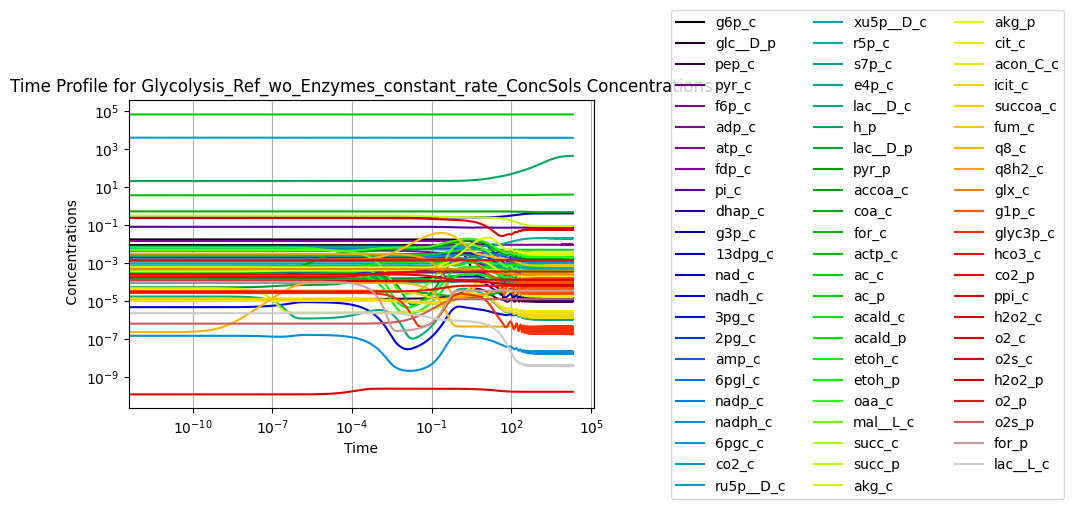

In [69]:
reference_model = model.copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes_constant_rate"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(
    reference_model,
    time=(0, tfinal),
    perturbations={"glc__D_b":"0.0025168795*0.1*(sin(t/10)+1)"}
)
conc_sol_orig.view_time_profile()

In [70]:
conc_df = conc_sol_orig.to_frame()
conc_df

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
2.494698e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
4.989396e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
7.484093e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
1.527795e-11,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.033632e+04,0.000673,0.000158,0.000013,0.000162,0.000223,0.003611,0.009227,0.001837,0.074114,0.001000,...,0.000357,0.000133,1.703559e-10,0.057541,0.000070,0.001393,0.001438,1.259266e-05,0.000035,4.379628e-09
2.033677e+04,0.000643,0.000142,0.000013,0.000161,0.000219,0.003611,0.009227,0.001811,0.074137,0.000988,...,0.000357,0.000133,1.703559e-10,0.057558,0.000070,0.001393,0.001438,1.259266e-05,0.000035,4.381648e-09
2.033721e+04,0.000615,0.000127,0.000013,0.000160,0.000215,0.003611,0.009227,0.001785,0.074159,0.000977,...,0.000357,0.000133,1.703559e-10,0.057580,0.000070,0.001393,0.001438,1.259266e-05,0.000035,4.383077e-09


In [71]:
flux_df = flux_sol_orig.to_frame()
flux_df

,GLCptspp,PGI,PFK,FBP,FBA,TPI,GAPD,PGK,PGM,ENO,...,SK_q8_c,SK_q8h2_c,SK_glx_c,SK_hco3_c,SK_co2_p,SK_ppi_c,SK_h2o2_c,SK_o2_c,SK_o2s_c,SK_for_p
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.494698e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,1.328719e-07,9.845200e-12,6.731993e-19,6.723015e-16,1.184592e-12,4.993303e-15,1.102797e-14,6.696806e-12,4.771907e-20,7.111373e-15
4.989396e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,2.657433e-07,1.969036e-11,1.346399e-18,1.344603e-15,2.369298e-12,9.986607e-15,2.205594e-14,1.339359e-11,9.543813e-20,1.423427e-14
7.484093e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,3.986142e-07,2.953548e-11,2.019598e-18,2.016905e-15,3.554117e-12,1.497991e-14,3.308391e-14,2.009034e-11,1.431572e-19,2.136869e-14
1.527795e-11,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,8.137217e-07,6.029304e-11,4.125568e-18,4.117272e-15,7.256431e-12,3.058004e-14,6.753715e-14,4.101196e-11,2.921038e-19,4.373287e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.033632e+04,0.000073,0.000024,0.000467,0.000039,0.000486,0.000523,0.001568,-0.001569,-0.001931,0.001933,...,8.111615e-05,8.110713e-05,5.560162e-06,9.063793e-05,8.901418e-03,3.394568e-04,2.819638e-07,6.279997e-03,5.639277e-07,3.653189e-04
2.033677e+04,0.000066,0.000020,0.000459,0.000038,0.000479,0.000517,0.001555,-0.001556,-0.001919,0.001921,...,8.111945e-05,8.110725e-05,5.560200e-06,9.063788e-05,8.901416e-03,3.394303e-04,2.819638e-07,6.279402e-03,5.639277e-07,3.653214e-04
2.033721e+04,0.000059,0.000016,0.000452,0.000038,0.000472,0.000511,0.001541,-0.001542,-0.001907,0.001908,...,8.112275e-05,8.110741e-05,5.560242e-06,9.063783e-05,8.901414e-03,3.394047e-04,2.819638e-07,6.278608e-03,5.639277e-07,3.653238e-04


In [72]:
flux_df.GLCptspp.mean()

0.0003464647524661093

In [73]:
0.0025168795*0.1

0.00025168795

## Implementing lifelines

In [74]:
qS_arr = np.load(file='../../../process_sim_and_scale-down_design/lifelines_npy_files/qS_cell_lifelines1.npy')
comp_id_arr = np.load(file='../../../process_sim_and_scale-down_design/lifelines_npy_files/comp_id_cell_lifelines1.npy')

In [75]:
qS_df = pd.DataFrame(qS_arr.T)
comp_id_df = pd.DataFrame(comp_id_arr.T)
qS_rel_df = pd.DataFrame(qS_arr.T/0.8)

In [76]:
qS_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.031275,0.010553,0.248234,0.017822,0.048027,0.008250,0.017822,0.052529,0.008250,0.017822,...,0.017822,0.157810,0.015618,0.052529,0.031275,0.015618,0.015618,0.009765,0.031275,0.012815
1,0.031275,0.010553,0.248234,0.017822,0.048027,0.008250,0.017822,0.052529,0.008250,0.017822,...,0.017822,0.157810,0.015618,0.052529,0.031275,0.015618,0.015618,0.009765,0.031275,0.012815
2,0.031275,0.010553,0.248234,0.017822,0.048027,0.008250,0.017822,0.052529,0.008250,0.017822,...,0.017822,0.157810,0.015618,0.052529,0.031275,0.015618,0.015618,0.009765,0.031275,0.012815
3,0.031275,0.009698,0.248234,0.017822,0.048027,0.008250,0.017822,0.052529,0.008250,0.017822,...,0.017822,0.157810,0.015618,0.052529,0.031275,0.015618,0.015618,0.009765,0.031275,0.012815
4,0.031275,0.009698,0.248234,0.017822,0.048027,0.008250,0.017822,0.052529,0.008250,0.017822,...,0.017822,0.157810,0.015618,0.052529,0.031275,0.015618,0.015618,0.009765,0.031275,0.012815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239996,0.059280,0.157810,0.059280,0.119952,0.010553,0.119952,0.052529,0.012815,0.031275,0.052529,...,0.059280,0.248234,0.454167,0.248234,0.454167,0.012815,0.454167,0.157810,0.048027,0.129802
239997,0.059280,0.157810,0.059280,0.119952,0.010553,0.119952,0.052529,0.012815,0.031275,0.052529,...,0.119952,0.248234,0.454167,0.248234,0.454167,0.012815,0.454167,0.157810,0.048027,0.129802
239998,0.059280,0.157810,0.119952,0.119952,0.010553,0.119952,0.052529,0.012815,0.031275,0.052529,...,0.119952,0.248234,0.454167,0.248234,0.454167,0.012815,0.454167,0.157810,0.048027,0.129802
239999,0.059280,0.157810,0.119952,0.119952,0.010553,0.119952,0.052529,0.012815,0.031275,0.052529,...,0.119952,0.248234,0.454167,0.248234,0.454167,0.012815,0.454167,0.149145,0.048027,0.129802


In [77]:
qS_rel_df.mean(axis=0).mean()*0.8

0.09985807008170794

In [78]:
comp_id_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,20.0,1.0,12.0,3.0,6.0,2.0,3.0,7.0,2.0,3.0,...,3.0,25.0,4.0,7.0,20.0,4.0,4.0,17.0,20.0,5.0
1,20.0,1.0,12.0,3.0,6.0,2.0,3.0,7.0,2.0,3.0,...,3.0,25.0,4.0,7.0,20.0,4.0,4.0,17.0,20.0,5.0
2,20.0,1.0,12.0,3.0,6.0,2.0,3.0,7.0,2.0,3.0,...,3.0,25.0,4.0,7.0,20.0,4.0,4.0,17.0,20.0,5.0
3,20.0,15.0,12.0,3.0,6.0,2.0,3.0,7.0,2.0,3.0,...,3.0,25.0,4.0,7.0,20.0,4.0,4.0,17.0,20.0,5.0
4,20.0,15.0,12.0,3.0,6.0,2.0,3.0,7.0,2.0,3.0,...,3.0,25.0,4.0,7.0,20.0,4.0,4.0,17.0,20.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239996,21.0,25.0,21.0,10.0,1.0,10.0,7.0,5.0,20.0,7.0,...,21.0,12.0,26.0,12.0,26.0,5.0,26.0,25.0,6.0,11.0
239997,21.0,25.0,21.0,10.0,1.0,10.0,7.0,5.0,20.0,7.0,...,10.0,12.0,26.0,12.0,26.0,5.0,26.0,25.0,6.0,11.0
239998,21.0,25.0,10.0,10.0,1.0,10.0,7.0,5.0,20.0,7.0,...,10.0,12.0,26.0,12.0,26.0,5.0,26.0,25.0,6.0,11.0
239999,21.0,25.0,10.0,10.0,1.0,10.0,7.0,5.0,20.0,7.0,...,10.0,12.0,26.0,12.0,26.0,5.0,26.0,14.0,6.0,11.0


In [79]:
qS_rel_arr = qS_arr.T/0.8

In [80]:
timestep = 0
qS_rel_arr[0][timestep]

0.03909355739011196

In [81]:
qS_rel_arr[0].shape

(1000,)

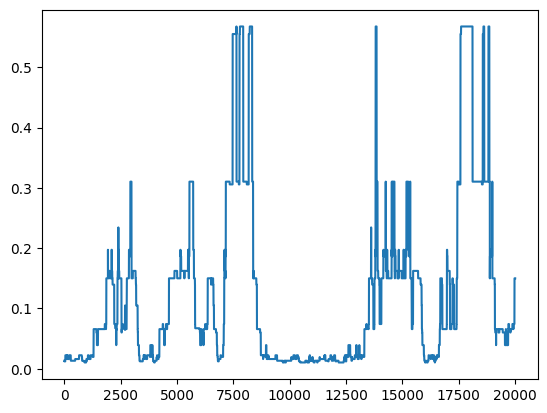

In [82]:
plt.plot(qS_rel_arr.T[1][:int(240000/2/6)])

In [83]:
timestep = 0
qS_rel = qS_rel_arr[0][timestep] 
glc__D_b_max = 0.0025168795
glc__D_b_value = glc__D_b_max*qS_rel

1. Loading the model into the Simulation object is actually one of the lengthier parts of the simulation (it has to recompile the model in C++ at that time). Only utilize different simulation objects for models with different ODE structures. For different initial conditions, those can be altered directly in the simulation object. 
2. As durations of high and low glucose vary, you may want to make sure that the number of time points/steps the simulator utilizes makes sense. For example, you likely don't need 10000 time points returned for a time interval of [0, 0.1], so checking this number is important.
3. Turn off all verbosity, the print to screen or log to console actions can sometimes be more time consuming than the simulation.
4. Oscillation-like simulations also require careful selection of simulator parameters. If you check the "integrator" attribute of the Simulation object, you should be able to see those options.
5. If these are just simulations to find a steady state after the perturbation, you could also consider using the "steady_state_solver" to find the steady state through a Newtonian root finding algorithm. These tend to be faster computations than doing the full integrations over time, and the steady state is determined by whether the sum of squares of the rates of change is below a particular threshold value (default 1E-6).
6. Make sure that the integrator has the option set to allow variable time steps, formatting the output as evenly spaced can take longer and is not always necessary.


In [84]:
reference_model = model.copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes_constant_rate"
sim = Simulation(reference_model=reference_model,id=None,verbose=False,variable_step_size=False,)

tfinal = 0.03 # time of one step

Getting time points
Setting output selections
Setting simulation values for 'Glycolysis_Ref_wo_Enzymes_constant_rate'
sim_values_to_set
try setting perturbations
Went into reset = False if loop of _set_values_in_roadrunner
Finished for loop of _set_values_in_roadrunner
Simulating 'Glycolysis_Ref_wo_Enzymes_constant_rate'
Simulation for 'Glycolysis_Ref_wo_Enzymes_constant_rate' successful
Adding 'Glycolysis_Ref_wo_Enzymes_constant_rate' simulation solutions to output
Updating stored solutions


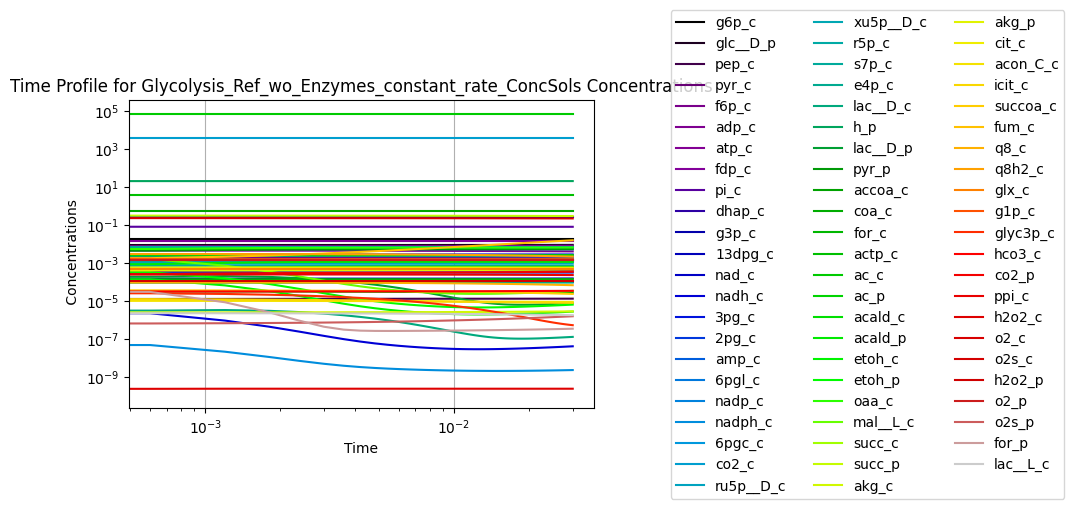

In [86]:
conc_sol_orig, flux_sol_orig = sim.simulate(
    reference_model,
    time=(0, tfinal),
    verbose=True
)
conc_sol_orig.view_time_profile()

# Simulating timesteps

In [90]:
reference_model = model.copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes_constant_rate"
sim = Simulation(reference_model=reference_model,id=None,verbose=False,variable_step_size=False,)

tfinal = 0.03 # time of one step

Getting time points
Setting output selections
Setting simulation values for 'Glycolysis_Ref_wo_Enzymes_constant_rate'
sim_values_to_set
try setting perturbations
Went into reset = False if loop of _set_values_in_roadrunner
Finished for loop of _set_values_in_roadrunner
Simulating 'Glycolysis_Ref_wo_Enzymes_constant_rate'
Simulation for 'Glycolysis_Ref_wo_Enzymes_constant_rate' successful
Adding 'Glycolysis_Ref_wo_Enzymes_constant_rate' simulation solutions to output
Updating stored solutions


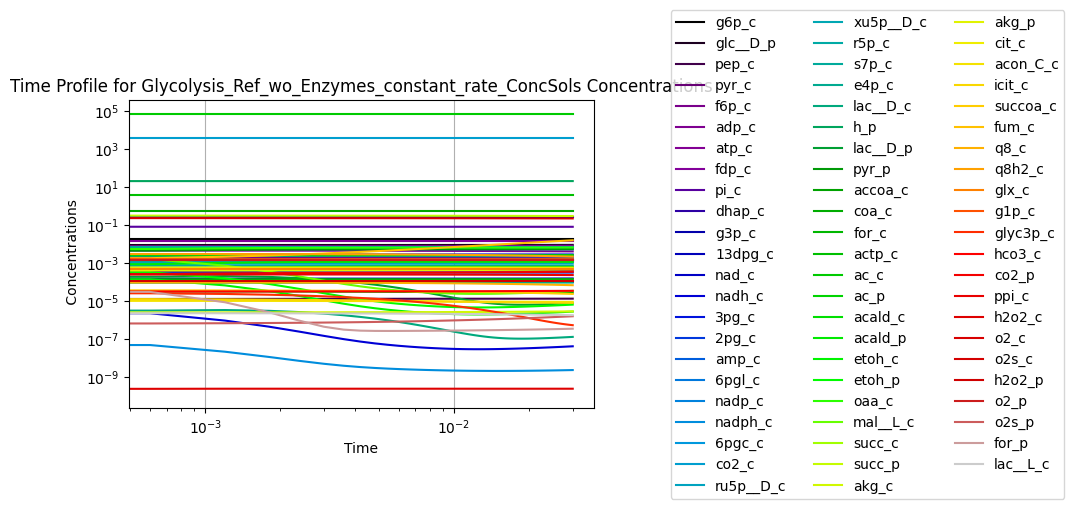

In [92]:
conc_sol_orig, flux_sol_orig = sim.simulate(
    reference_model,
    time=(0, tfinal),
    verbose=True
)
conc_sol_orig.view_time_profile()

## Adjusting settings

In [106]:
sim.integrator

< roadrunner.Integrator() "cvode" 'relative_tolerance': 1e-06, 'absolute_tolerance': 1e-12, 'stiff': true, 'maximum_bdf_order': 5, 'maximum_adams_order': 12, 'maximum_num_steps': 20000, 'maximum_time_step': 0, 'minimum_time_step': 0, 'initial_time_step': 0, 'multiple_steps': false, 'variable_step_size': false, 'max_output_rows': 100000 >

In [109]:
sim.integrator.maximum_num_steps = 1000

In [122]:
conc_sol_orig, flux_sol_orig = sim.simulate(
    reference_model,
    time=(0, tfinal),
    verbose=False # set verbosity false
)
# conc_sol_orig.view_time_profile()

sim_values_to_set
try setting perturbations
Went into reset = False if loop of _set_values_in_roadrunner
Finished for loop of _set_values_in_roadrunner


In [159]:
sim_values_to_set_original = sim._get_all_values_for_sim(reference_model)

In [158]:
new_ics = conc_sol_orig.to_frame().iloc[-1].to_dict()

In [172]:
sim.reference_model.update_initial_conditions(new_ics,verbose=False)

In [173]:
sim_values_to_set_new = sim._get_all_values_for_sim(sim.reference_model)

### Test if this takes over the new ics

In [174]:
sim_values_to_set_new

{'g6p_c': 0.017583432795539485,
 'glc__D_p': 0.008899422406411254,
 'pep_c': 1.2880497319768143e-05,
 'pyr_c': 0.00046506967137095994,
 'f6p_c': 0.0019438756335989958,
 'adp_c': 0.004531201374508639,
 'atp_c': 0.0076774942935511695,
 'fdp_c': 0.014506535075564014,
 'h_c': 1,
 'h2o_c': 1,
 'pi_c': 0.08129135011206884,
 'dhap_c': 0.0059758606288585064,
 'g3p_c': 0.00010567142609605275,
 '_13dpg_c': 0.0001520823421292135,
 'nad_c': 0.25099900048338136,
 'nadh_c': 4.764043110716475e-06,
 '_3pg_c': 0.002837023561690988,
 '_2pg_c': 0.00031501479596341244,
 'amp_c': 0.001251640685478358,
 '_6pgl_c': 0.0023879294013646117,
 'nadp_c': 0.0016280318315082894,
 'nadph_c': 1.5113516209193612e-07,
 '_6pgc_c': 0.005362954720671204,
 'co2_c': 3949.8414519285084,
 'ru5p__D_c': 0.0009181568283335704,
 'xu5p__D_c': 0.0012068333347421962,
 'r5p_c': 0.0007153383970307151,
 's7p_c': 0.006809897555087404,
 'e4p_c': 9.229156364019546e-05,
 'lac__D_c': 1.7569227804798876e-05,
 'h_p': 20.438989225561286,
 'lac_

In [175]:
sim_values_to_set_original

{'g6p_c': 0.017583432795539485,
 'glc__D_p': 0.008899422406411254,
 'pep_c': 1.2880497319768143e-05,
 'pyr_c': 0.00046506967137095994,
 'f6p_c': 0.0019438756335989958,
 'adp_c': 0.004531201374508639,
 'atp_c': 0.0076774942935511695,
 'fdp_c': 0.014506535075564014,
 'h_c': 1,
 'h2o_c': 1,
 'pi_c': 0.08129135011206884,
 'dhap_c': 0.0059758606288585064,
 'g3p_c': 0.00010567142609605275,
 '_13dpg_c': 0.0001520823421292135,
 'nad_c': 0.25099900048338136,
 'nadh_c': 4.764043110716475e-06,
 '_3pg_c': 0.002837023561690988,
 '_2pg_c': 0.00031501479596341244,
 'amp_c': 0.001251640685478358,
 '_6pgl_c': 0.0023879294013646117,
 'nadp_c': 0.0016280318315082894,
 'nadph_c': 1.5113516209193612e-07,
 '_6pgc_c': 0.005362954720671204,
 'co2_c': 3949.8414519285084,
 'ru5p__D_c': 0.0009181568283335704,
 'xu5p__D_c': 0.0012068333347421962,
 'r5p_c': 0.0007153383970307151,
 's7p_c': 0.006809897555087404,
 'e4p_c': 9.229156364019546e-05,
 'lac__D_c': 1.7569227804798876e-05,
 'h_p': 20.438989225561286,
 'lac_

In [176]:
sim.reference_model.initial_conditions

{<MassMetabolite g6p_c at 0x1d714d10708>: 0.017375907398134393,
 <MassMetabolite glc__D_p at 0x1d81da8c948>: 0.009035359053400785,
 <MassMetabolite pep_c at 0x1d708e18508>: 1.3429078938983744e-05,
 <MassMetabolite pyr_c at 0x1d7080f5448>: 0.00041052828191921487,
 <MassMetabolite f6p_c at 0x1d81a10a348>: 0.0019394001040952758,
 <MassMetabolite adp_c at 0x1d81da8fe48>: 0.004106938000299247,
 <MassMetabolite atp_c at 0x1d81da8fe88>: 0.008109925197618696,
 <MassMetabolite fdp_c at 0x1d8009bea08>: 0.014508801213036368,
 <MassMetabolite h_c at 0x1d8009bed88>: 1,
 <MassMetabolite h2o_c at 0x1d81da8f4c8>: 1,
 <MassMetabolite pi_c at 0x1d71e2c7208>: 0.08084207235187457,
 <MassMetabolite dhap_c at 0x1d71e2c7148>: 0.0060022051378843975,
 <MassMetabolite g3p_c at 0x1d7e771efc8>: 0.00010145719744503238,
 <MassMetabolite _13dpg_c at 0x1d891cdff88>: 0.0001552086354624748,
 <MassMetabolite nad_c at 0x1d891cdffc8>: 0.2510494833281103,
 <MassMetabolite nadh_c at 0x1d891cdf808>: 4.197936419175029e-08,
 <

In [196]:
sim._simulation_values[0]['init_conds']['g6p_c']

0.017583432795539485

# Exploring roadrunner instance

In [86]:
rr = sim.roadrunner
rr.g6p_c

0.0175834327955713

In [87]:
sim._get_all_values_for_sim(reference_model)

{'g6p_c': 0.01758343279557134,
 'glc__D_p': 0.008899422406428256,
 'pep_c': 1.2880497319789994e-05,
 'pyr_c': 0.0004650696713719641,
 'f6p_c': 0.0019438756336022226,
 'adp_c': 0.0045312013745109165,
 'atp_c': 0.007677494293553563,
 'fdp_c': 0.014506535075566977,
 'h_c': 1,
 'h2o_c': 1,
 'pi_c': 0.08129135011212457,
 'dhap_c': 0.005975860628860894,
 'g3p_c': 0.00010567142609610644,
 '_13dpg_c': 0.0001520823421292867,
 'nad_c': 0.250999000484079,
 'nadh_c': 4.764043110728762e-06,
 '_3pg_c': 0.0028370235616990667,
 '_2pg_c': 0.00031501479596432734,
 'amp_c': 0.0012516406854820043,
 '_6pgl_c': 0.0023879294013715406,
 'nadp_c': 0.0016280318315134805,
 'nadph_c': 1.511351620923842e-07,
 '_6pgc_c': 0.005362954720681483,
 'co2_c': 3949.841451927835,
 'ru5p__D_c': 0.000918156828335866,
 'xu5p__D_c': 0.0012068333347450722,
 'r5p_c': 0.0007153383970324038,
 's7p_c': 0.006809897555109402,
 'e4p_c': 9.22915636403871e-05,
 'lac__D_c': 1.756922780484057e-05,
 'h_p': 20.438989225563848,
 'lac__D_p': 5

In [88]:
# Get roadrunner instance
rr = sim.roadrunner

Trying to understand _set_simulation_values, since it takes so long. I'm skipping all log messages

In [89]:
rr = sim.roadrunner

In [90]:
sim_values_to_set = sim._get_all_values_for_sim(reference_model)

Need to set perturbations


In [91]:
from six import iteritems
from sympy import Basic, Symbol, sympify

In [92]:
perturbations={"glc__D_b":0.00025168795}

In [93]:
def _format_perturbations_input(sim,perturbations,verbose=False):
    formatted_perturbations = {}
    sim_values = sim._get_all_values_for_sim(sim.reference_model)
    
    for key, value in iteritems(perturbations):
        try:
            value = float(value)
        except (ValueError, TypeError):
            if key in sim.reference_model.boundary_metabolites or key in str(value):
                value = sympify(value, locals={key: Symbol(key)})
            else:
                print('error')
        formatted_perturbations[key] = value
    return formatted_perturbations

In [94]:
# Parse the perturbations and format the input to be used
perturbations = _format_perturbations_input(sim,perturbations)

now we continue

In [95]:
for key, value in iteritems(perturbations):
    # Perturb value to a number if value is float
    if isinstance(value, float):
        sim_values_to_set[key] = value
        continue
    
    value = value.subs({key: sim_values_to_set[key]})
    value = float(value)
    sim_values_to_set[key] = value
    continue
    
rr = sim._set_values_in_roadrunner(model, False, sim_values_to_set)

In [96]:
def _make_init_cond(metabolite_str):
    return "init(" + metabolite_str + ")"

In [97]:
rr = sim.roadrunner

for key in sim_values_to_set.keys():
    
    value = sim_values_to_set[key]
    
    rr_keys = rr.keys()
    
#     if isinstance(value, Basic):
#         print(value,' basic')
#         break
    if _make_init_cond(key) in rr_keys:
        rr.setValue(_make_init_cond(key), value)
        print(key,' init set')
#     print(_make_init_cond(key),' init set')
#     else:
#         rr.setValue(key, value)
#         print(key,' set')
#         break

g6p_c  init set
glc__D_p  init set
pep_c  init set
pyr_c  init set
f6p_c  init set
adp_c  init set
atp_c  init set
fdp_c  init set
h_c  init set
h2o_c  init set
pi_c  init set
dhap_c  init set
g3p_c  init set
_13dpg_c  init set
nad_c  init set
nadh_c  init set
_3pg_c  init set
_2pg_c  init set
amp_c  init set
_6pgl_c  init set
nadp_c  init set
nadph_c  init set
_6pgc_c  init set
co2_c  init set
ru5p__D_c  init set
xu5p__D_c  init set
r5p_c  init set
s7p_c  init set
e4p_c  init set
lac__D_c  init set
h_p  init set
lac__D_p  init set
pyr_p  init set
accoa_c  init set
coa_c  init set
for_c  init set
actp_c  init set
ac_c  init set
ac_p  init set
acald_c  init set
acald_p  init set
etoh_c  init set
etoh_p  init set
oaa_c  init set
mal__L_c  init set
succ_c  init set
succ_p  init set
akg_c  init set
akg_p  init set
cit_c  init set
acon_C_c  init set
icit_c  init set
succoa_c  init set
fum_c  init set
q8_c  init set
q8h2_c  init set
glx_c  init set
g1p_c  init set
glyc3p_c  init set
hco3_c  

v_SK_coa_c  init set
v_SK_for_c  init set
v_SK_ac_c  init set
v_SK_ac_p  init set
v_SK_acald_c  init set
v_SK_oaa_c  init set
v_SK_mal__L_c  init set
v_SK_succ_c  init set
v_SK_akg_c  init set
v_SK_cit_c  init set
v_SK_icit_c  init set
v_SK_succoa_c  init set
v_SK_fum_c  init set
v_SK_q8_c  init set
v_SK_q8h2_c  init set
v_SK_glx_c  init set
v_SK_hco3_c  init set
v_SK_co2_p  init set
v_SK_ppi_c  init set
v_SK_h2o2_c  init set
v_SK_o2_c  init set
v_SK_o2s_c  init set
v_SK_for_p  init set
g6p_b  init set
glc__D_b  init set
pep_b  init set
pyr_b  init set
f6p_b  init set
adp_b  init set
atp_b  init set
fdp_b  init set
h_b  init set
h2o_b  init set
pi_b  init set
dhap_b  init set
g3p_b  init set
nad_b  init set
nadh_b  init set
_3pg_b  init set
amp_b  init set
nadp_b  init set
nadph_b  init set
_6pgc_b  init set
co2_b  init set
ru5p__D_b  init set
xu5p__D_b  init set
r5p_b  init set
e4p_b  init set
accoa_b  init set
coa_b  init set
for_b  init set
ac_b  init set
acald_b  init set
oaa_b  in

# This is how I want to change the _set_values_in_roadrunner function

Testing if _make_init_cond(key) in rr.keys() takes too long, but I checked and it applies to all cases

In [295]:
for key, value in iteritems(sim_values_to_set):
#     if isinstance(value, Basic):
#         continue
#     if _make_init_cond(key) in rr.keys():
#         rr.setValue(_make_init_cond(key), value)
    rr.setValue(_make_init_cond(key), value)
#     else:
#         rr.setValue(key, value)

In [233]:
sim_values_to_set['g6p_c'] = 1.0

In [234]:
sim_values_to_set['g6p_c']

1.0

In [235]:
rr.setValues(sim_values_to_set.keys(),sim_values_to_set.values())

In [236]:
rr.g6p_c

1.0

In [237]:
_make_init_cond('g6p_c')

'init(g6p_c)'

the function _set_values_in_roadrunner inside _set_simulation_values is what takes so long

In [148]:
rr = sim.roadrunner
rr.keys()

['g6p_c',
 'glc__D_p',
 'pep_c',
 'pyr_c',
 'f6p_c',
 'adp_c',
 'atp_c',
 'fdp_c',
 'pi_c',
 'dhap_c',
 'g3p_c',
 '_13dpg_c',
 'nad_c',
 'nadh_c',
 '_3pg_c',
 '_2pg_c',
 'amp_c',
 '_6pgl_c',
 'nadp_c',
 'nadph_c',
 '_6pgc_c',
 'co2_c',
 'ru5p__D_c',
 'xu5p__D_c',
 'r5p_c',
 's7p_c',
 'e4p_c',
 'lac__D_c',
 'h_p',
 'lac__D_p',
 'pyr_p',
 'accoa_c',
 'coa_c',
 'for_c',
 'actp_c',
 'ac_c',
 'ac_p',
 'acald_c',
 'acald_p',
 'etoh_c',
 'etoh_p',
 'oaa_c',
 'mal__L_c',
 'succ_c',
 'succ_p',
 'akg_c',
 'akg_p',
 'cit_c',
 'acon_C_c',
 'icit_c',
 'succoa_c',
 'fum_c',
 'q8_c',
 'q8h2_c',
 'glx_c',
 'g1p_c',
 'glyc3p_c',
 'hco3_c',
 'co2_p',
 'ppi_c',
 'h2o2_c',
 'o2_c',
 'o2s_c',
 'h2o2_p',
 'o2_p',
 'o2s_p',
 'for_p',
 'lac__L_c',
 'h_c',
 'h2o_c',
 '[g6p_c]',
 '[glc__D_p]',
 '[pep_c]',
 '[pyr_c]',
 '[f6p_c]',
 '[adp_c]',
 '[atp_c]',
 '[fdp_c]',
 '[pi_c]',
 '[dhap_c]',
 '[g3p_c]',
 '[_13dpg_c]',
 '[nad_c]',
 '[nadh_c]',
 '[_3pg_c]',
 '[_2pg_c]',
 '[amp_c]',
 '[_6pgl_c]',
 '[nadp_c]',
 '[nadph

In [240]:
rr['init(g6p_c)']

0.01758343279557134

In [211]:
rr = sim.roadrunner

In [213]:
rr.g6p_c

1.288049731979e-05

In [195]:
sim._get_all_values_for_sim(reference_model)

{'g6p_c': 0.01758343279557134,
 'glc__D_p': 0.008899422406428256,
 'pep_c': 1.2880497319789994e-05,
 'pyr_c': 0.0004650696713719641,
 'f6p_c': 0.0019438756336022226,
 'adp_c': 0.0045312013745109165,
 'atp_c': 0.007677494293553563,
 'fdp_c': 0.014506535075566977,
 'h_c': 1,
 'h2o_c': 1,
 'pi_c': 0.08129135011212457,
 'dhap_c': 0.005975860628860894,
 'g3p_c': 0.00010567142609610644,
 '_13dpg_c': 0.0001520823421292867,
 'nad_c': 0.250999000484079,
 'nadh_c': 4.764043110728762e-06,
 '_3pg_c': 0.0028370235616990667,
 '_2pg_c': 0.00031501479596432734,
 'amp_c': 0.0012516406854820043,
 '_6pgl_c': 0.0023879294013715406,
 'nadp_c': 0.0016280318315134805,
 'nadph_c': 1.511351620923842e-07,
 '_6pgc_c': 0.005362954720681483,
 'co2_c': 3949.841451927835,
 'ru5p__D_c': 0.000918156828335866,
 'xu5p__D_c': 0.0012068333347450722,
 'r5p_c': 0.0007153383970324038,
 's7p_c': 0.006809897555109402,
 'e4p_c': 9.22915636403871e-05,
 'lac__D_c': 1.756922780484057e-05,
 'h_p': 20.438989225563848,
 'lac__D_p': 5

In [207]:
conc_sol_orig.to_frame()

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,2.334096e-01,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
2.494698e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,2.334096e-01,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
4.989396e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,2.334096e-01,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
7.484093e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,2.334096e-01,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
1.527795e-11,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,2.334096e-01,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.397405e+05,0.054578,0.008630,0.000028,0.002285,0.006363,0.004107,0.008156,0.176904,0.054600,0.024887,...,0.000272,0.000126,1.703559e-10,2.711755e-07,0.000070,0.001393,0.001438,1.259266e-05,0.000066,0.000031
9.591154e+05,0.054583,0.008626,0.000028,0.002288,0.006364,0.004107,0.008156,0.176986,0.054598,0.024892,...,0.000272,0.000126,1.703559e-10,2.711336e-07,0.000070,0.001393,0.001438,1.259266e-05,0.000066,0.000031
9.784902e+05,0.054588,0.008623,0.000028,0.002290,0.006365,0.004107,0.008156,0.177062,0.054596,0.024897,...,0.000271,0.000126,1.703559e-10,2.710946e-07,0.000070,0.001393,0.001438,1.259266e-05,0.000066,0.000031
